# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import sklearn

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, auc

# Magic word for producing visualizations in notebook
%matplotlib inline

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
print("The shape of azdias dataset is {}".format(azdias.shape))

The shape of azdias dataset is (891221, 366)


In [6]:
#Take a look at the azdias first 5 rows
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
#ake a look at desription of the azdias frame
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [4]:
#For exercise, only play with a part of the data
azdias=azdias.sample(frac=0.1,replace=False,random_state=42)
azdias.shape

(89122, 366)

In [5]:
azdias.to_pickle("azdias.pkl")

In [4]:
azdias=pd.read_pickle("azdias.pkl")

In [5]:
# Load attributes
attribute= pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=1)
#Forward fill the cells with the previous value
attribute= attribute.fillna(method='ffill') 

In [6]:
attribute.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,best-ager typology,0,no classification possible
NaN,AGER_TYP,best-ager typology,1,passive elderly
NaN,AGER_TYP,best-ager typology,2,cultural elderly
NaN,AGER_TYP,best-ager typology,3,experience-driven elderly


### Deal with  'unknown's

In [7]:
# Subset for unknowns from DIAS Attributes - Values 2017.xlsx data
attribute_unknown = attribute[(attribute['Meaning'].str.contains('unknown'))] 
attribute_unknown.head(5)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,BALLRAUM,distance to next urban centre,-1,unknown


In [14]:
list(attribute_unknown['Value'].unique())

[-1, '-1, 0', 0, '-1, 9', '-1']

In [8]:
# Columns where -1 should be replaced by NaNs
unknown_neg1=list(attribute_unknown[(attribute_unknown['Value'] == -1)]['Attribute'])
# Columns where -1 or 0 should be replaced by NaNs
unknown_neg10=list(attribute_unknown[(attribute_unknown['Value'] == "-1, 0")]['Attribute'])
# Columns where 0 should be replaced by NaNs
unknown_0=list(attribute_unknown[(attribute_unknown['Value'] == 0)]['Attribute'])
# Columns where -1 or 9 should be replaced by NaNs
unknown_neg19=list(attribute_unknown[(attribute_unknown['Value'] == "-1, 9")]['Attribute'])
# Columns where -1 should be replaced by NaNs
unknown_neg1_str=list(attribute_unknown[(attribute_unknown['Value'] == "-1")]['Attribute'])

In [9]:
# Replace unknowns with NaNs
for col in azdias.columns:
    if col in unknown_neg1:
        azdias[col] = azdias[col].replace(-1, np.NaN)
    elif col in unknown_neg10:
        azdias[col] = azdias[col].replace(-1, np.NaN)
        azdias[col] = azdias[col].replace(0, np.NaN)
    elif col in unknown_0:
        azdias[col] = azdias[col].replace(0, np.NaN)
    elif col in unknown_neg19:
        azdias[col] = azdias[col].replace(-1, np.NaN)
        azdias[col] = azdias[col].replace(9, np.NaN)
    elif col in unknown_neg1_str:
        azdias[col] = azdias[col].replace(-1, np.NaN)

### Remove unnecessary columns

In [16]:
azdias.nunique().sort_values(ascending=False)[:15]

LNR                           89122
EINGEFUEGT_AM                  2682
KBA13_ANZAHL_PKW               1248
ANZ_HAUSHALTE_AKTIV             229
ANZ_STATISTISCHE_HAUSHALTE      216
GEBURTSJAHR                     113
EXTSEL992                        56
VERDICHTUNGSRAUM                 46
CAMEO_DEU_2015                   45
CAMEO_INTL_2015                  43
LP_LEBENSPHASE_FEIN              41
D19_LETZTER_KAUF_BRANCHE         35
EINGEZOGENAM_HH_JAHR             33
MIN_GEBAEUDEJAHR                 32
ALTERSKATEGORIE_FEIN             25
dtype: int64

In [13]:
attributes=attribute["Attribute"].unique()
columns_no_attributes=np.setdiff1d(azdias.columns,attributes)
columns_no_attributes

array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST',
       'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG',
       'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERAR

In [14]:
azdias[columns_no_attributes].head(5)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EXTSEL992,FIRMENDICHTE,GEMEINDETYP,HH_DELTA_FLAG,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,KBA13_CCM_1401_2500,KBA13_GBZ,KBA13_HHZ,KBA13_KMH_210,KK_KUNDENTYP,KOMBIALTER,KONSUMZELLE,LNR,MOBI_RASTER,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
848815,1.0,12.0,NaN,NaN,NaN,NaN,0.0,4.0,3.0,51,5.0,3.0,2.0,3.0,4.0,3.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,D19_UNBEKANNT,0.0,0,0,0,0,0,0,5.0,0,0,0.0,0,0,0,0,10,10,10,0.0,0,0,1.0,1992-02-12 00:00:00,1994.0,NaN,2.0,11.0,NaN,1.0,3.0,3.0,2.0,5.0,3.0,3.0,5.0,3.0,NaN,4,1.0,956771,1.0,2.0,4.0,1.0,0.0,3.0,3.0,3.0,0.0,6.0,0.0,2.0,9.0,12.0,10.0
299816,1.0,21.0,NaN,NaN,NaN,NaN,0.0,1.0,3.0,24,1.0,5.0,4.0,2.0,1.0,2.0,2.0,3,0,0,6,0,5,0,0,6,0,3,0,0,6,0,0,0,1,6,0,D19_BANKEN_DIREKT,0.0,0,0,0,0,5,0,0.0,0,6,0.0,0,6,5,1,3,10,10,0.0,0,0,1.0,1992-02-10 00:00:00,2010.0,34.0,3.0,12.0,0.0,2.0,3.0,2.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,0.0,536767,2.0,3.0,5.0,4.0,0.0,3.0,2.0,5.0,0.0,17.0,1.0,1.0,2.0,3.0,3.0
570748,9.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0,24,4.0,4.0,4.0,3.0,3.0,2.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,NaN,NaN,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,10,10,10,NaN,0,0,1.0,1994-08-30 00:00:00,1998.0,NaN,4.0,40.0,0.0,2.0,2.0,0.0,0.0,1.0,4.0,5.0,3.0,3.0,NaN,1,0.0,393990,3.0,4.0,5.0,4.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,8.0,9.0,6.0
354371,9.0,15.0,NaN,NaN,NaN,NaN,0.0,1.0,4.0,23,3.0,2.0,3.0,3.0,4.0,5.0,4.0,0,0,0,0,3,6,0,0,5,0,0,0,0,0,0,2,0,2,0,0,D19_VERSICHERUNGEN,0.0,0,2,6,0,3,6,0.0,6,0,0.0,0,0,0,3,1,10,10,0.0,6,0,1.0,2005-10-11 00:00:00,2005.0,23.0,5.0,11.0,0.0,2.0,2.0,0.0,0.0,1.0,2.0,3.0,2.0,3.0,2.0,3,0.0,596074,5.0,1.0,5.0,5.0,0.0,3.0,5.0,5.0,1.0,8.0,0.0,NaN,2.0,3.0,4.0
329018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,NaN,NaN,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,10,10,10,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,586471,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
azdias[columns_no_attributes].nunique()

AKT_DAT_KL                        9
ALTERSKATEGORIE_FEIN             25
ALTER_KIND1                      17
ALTER_KIND2                      17
ALTER_KIND3                      14
ALTER_KIND4                      10
ANZ_KINDER                        7
ANZ_STATISTISCHE_HAUSHALTE      216
ARBEIT                            6
CAMEO_INTL_2015                  43
CJT_KATALOGNUTZER                 5
CJT_TYP_1                         5
CJT_TYP_2                         5
CJT_TYP_3                         5
CJT_TYP_4                         5
CJT_TYP_5                         5
CJT_TYP_6                         5
D19_BANKEN_DIREKT                 8
D19_BANKEN_GROSS                  7
D19_BANKEN_LOKAL                  8
D19_BANKEN_REST                   8
D19_BEKLEIDUNG_GEH                8
D19_BEKLEIDUNG_REST               8
D19_BILDUNG                       8
D19_BIO_OEKO                      7
D19_BUCH_CD                       8
D19_DIGIT_SERV                    8
D19_DROGERIEARTIKEL         

1. Columns that convey duplicate information<br/>
LP_FAMILIE_GROB and LP_FAMILIE_FEIN,LP_STATUS_GROB and LP_STATUS_FEIN ,LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN, CAMEO_DEUG_2015 and CAMEO_DEU_2015 focus on the same attributes, but FEINs and DEU are more detailed.So we could leave one from each pair.<br/>
Usually, it is better to keep detailed information, but  LP_LEBENSPHASE_FEIN has too many unique values. After considering all the factures together, LP_FAMILIE_GROB, LP_STATUS_GROB,LP_LEBENSPHASE_FEIN,CAMEO_DEUG_2015 can be dropped.

2. Columns with too many unique values or meaningless for analysis<br/>
LNR - an ID column<br/>
EINGEFUEGT_AM - a date column with unknown meaning (not in the attributes file) and with too many unique values<br/>
EINGEZOGENAM_HH_JAHR - a year column with unknown meaning (not in the attributes file)and with too many unique values<br/>
D19_LETZTER_KAUF_BRANCHE - a feature name colum (not in the attributes file)<br/>
MIN_GEBAEUDEJAHR - year the building was first mentioned in our database, irrelevant to the analysis

In [10]:
cols_drop1 = ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR', 'D19_LETZTER_KAUF_BRANCHE',\
                 "LP_FAMILIE_GROB","LP_STATUS_GROB","LP_LEBENSPHASE_FEIN","CAMEO_DEUG_2015"]

In [11]:
azdias.drop(cols_drop1, axis=1,inplace=True)

### Remove columns and rows with too many with missing values

#### Missing values in columns

In [12]:
missing_percent=azdias.isnull().mean().sort_values(ascending=False)
# Filter columns with more than 30% of data missing
missing_percent_30=missing_percent[missing_percent>0.3]

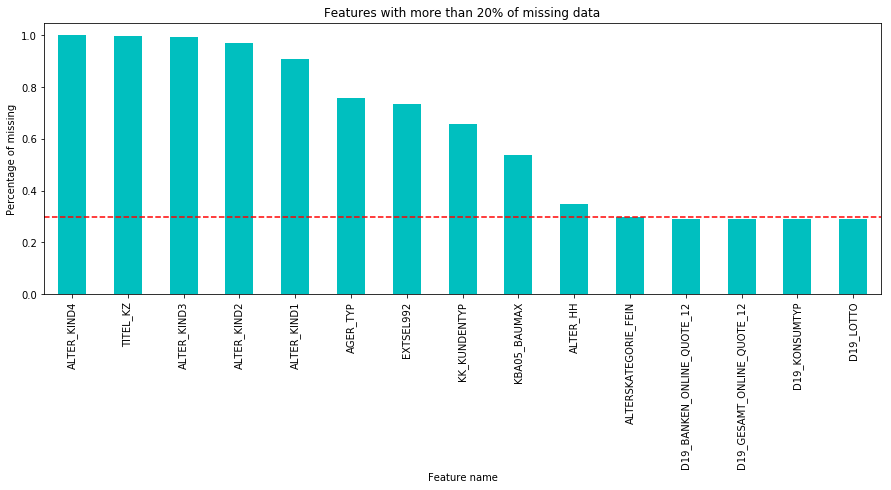

In [28]:
#Create figure and axes for plotting top 10 features with missing values
fig1,ax1=plt.subplots(figsize=(15,5))
missing_percent[:15].plot(kind='bar',ax=ax1,color="c")
ax1.set_xlabel('Feature name')
ax1.set_ylabel('Percentage of missing')
ax1.set_title('Features with more than 20% of missing data')
ax1.axhline(0.3, color = "r", linestyle = "--")

Drop columns which have more than 30% of data missing.

In [13]:
cols_drop2=list(missing_percent_30.index)

In [14]:
azdias.drop(cols_drop2, axis=1,inplace=True)
azdias.shape

(89122, 347)

#### Missing values in rows

In [15]:
missing_percent_row=azdias.isnull().mean(axis=1)

Text(0,0.5,'Number of rows')

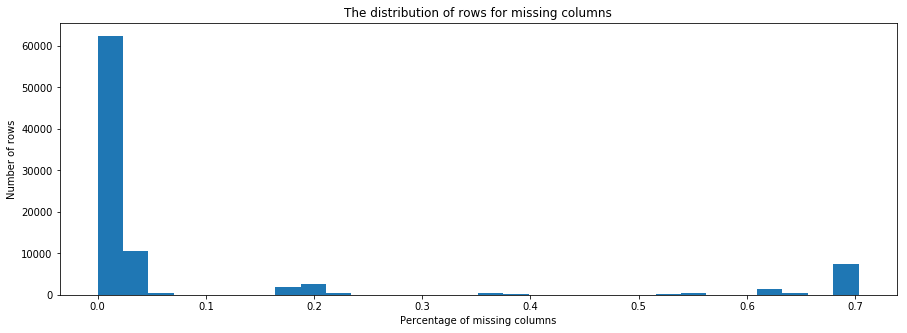

In [23]:
fig2,ax2=plt.subplots(figsize=(15,5))
missing_percent_row.plot(kind="hist",bins=30,ax=ax2)
ax2.set_title("The distribution of rows for missing columns")
ax2.set_xlabel("Percentage of missing columns")
ax2.set_ylabel("Number of rows")

A row with more than 50% of columns missing can be dropped.

In [24]:
print("Before dropping rows with more than 50% of columns missing, there are {} rows".format(azdias.shape[0]))

Before dropping rows with more than 50% of columns missing, there are 89122 rows


In [16]:
azdias.drop(list(missing_percent_row[missing_percent_row>0.5].index), axis=0,inplace=True)

In [26]:
print("After dropping rows with more than 50% of columns missing, there are {} rows".format(azdias.shape[0]))

After dropping rows with more than 50% of columns missing, there are 78967 rows


### Categorical variables

A categorical variable (sometimes called a nominal variable) is one that has two or more categories, but there is no intrinsic ordering to the categories. 

In [17]:
cat_cols = [
    #'AGER_TYP', has been removed because of too many null values
    'ANREDE_KZ',
    'CAMEO_DEU_2015',  
    'CJT_GESAMTTYP',    
    'GEBAEUDETYP',
    'GEBAEUDETYP_RASTER',
    'GFK_URLAUBERTYP',
    #"HAUSHALTSSTRUKTUR",not in the dataframe
    'HEALTH_TYP',
    'LP_FAMILIE_FEIN',
    'LP_STATUS_FEIN',
    'LP_LEBENSPHASE_GROB',
    'NATIONALITAET_KZ',
    'OST_WEST_KZ',
    'RETOURTYP_BK_S',
    'SHOPPER_TYP',
    # 'TITEL_KZ',has been removed because of too many null values
    'VERS_TYP',
    'ZABEOTYP',
# Assign dummy variable as categorical variables
    #'BIP_FLAG',not in the dataframe
    #"SOHO_FLAG",not in the dataframe
    'DSL_FLAG',
    'HH_DELTA_FLAG',
    'SOHO_KZ',
    'UNGLEICHENN_FLAG',
    'KONSUMZELLE',
]

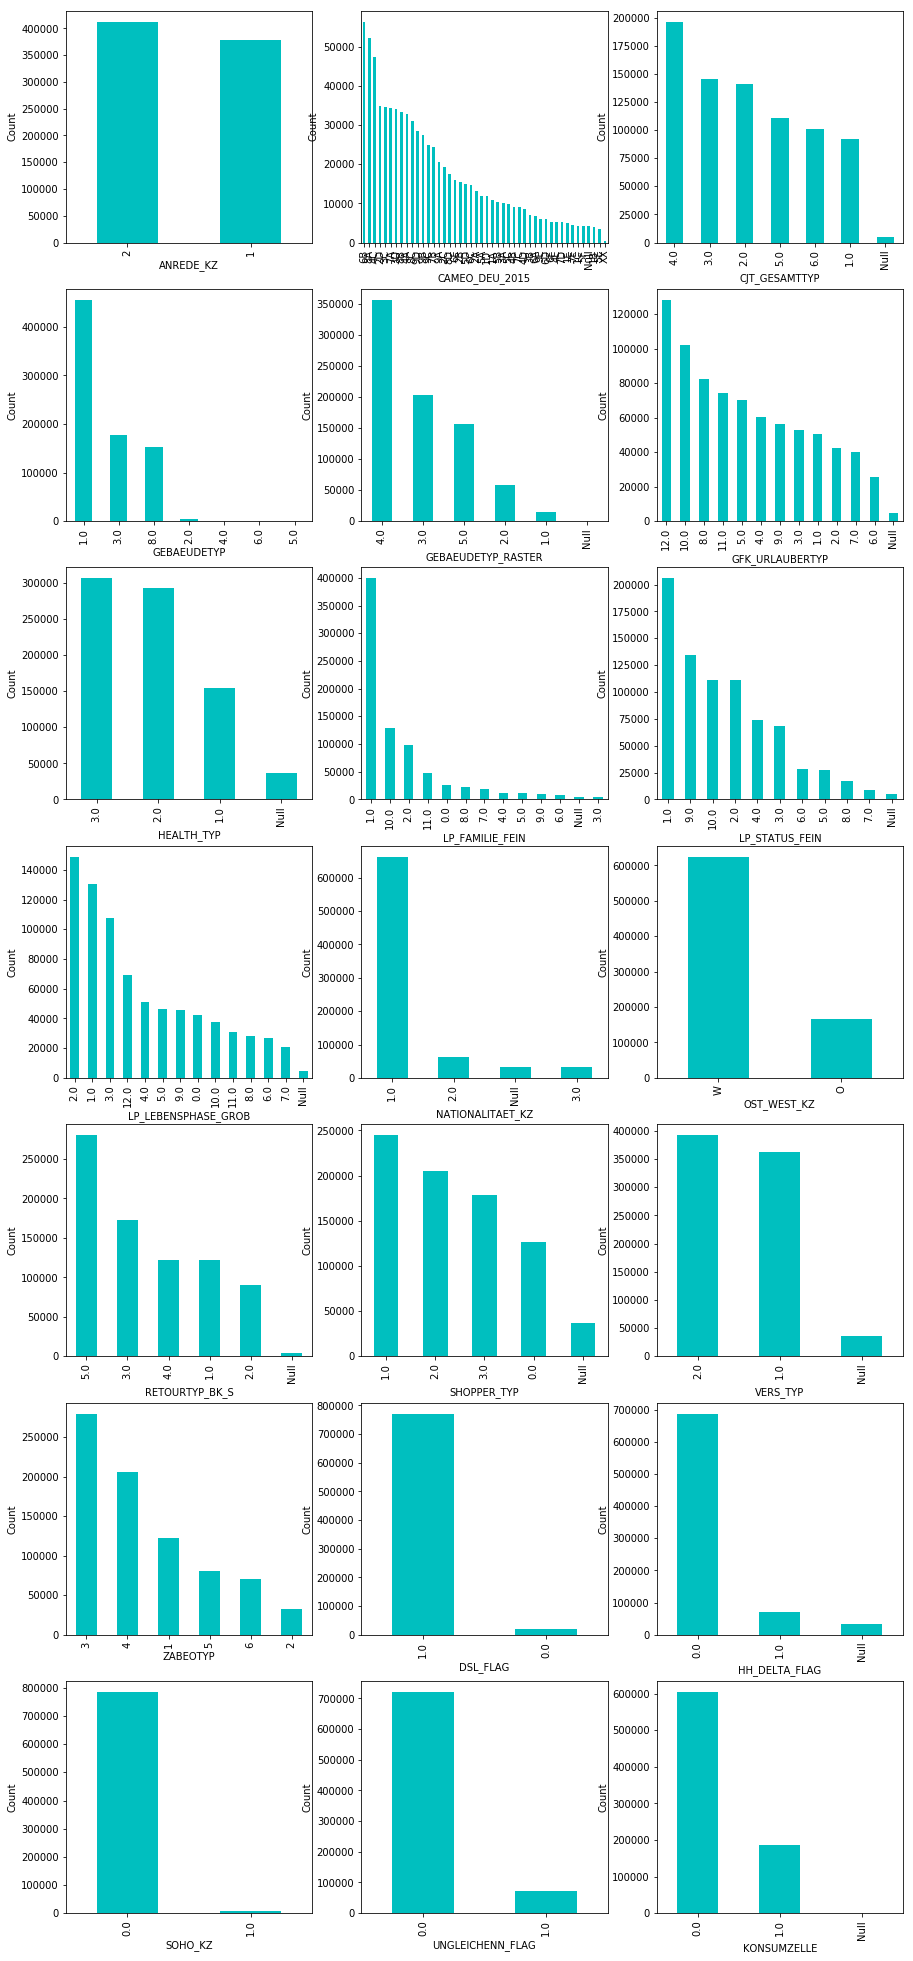

In [60]:
azdias_cat_df = azdias[cat_cols].copy()
# Plot all the categorical variables
fig3,((ax3_1,ax3_2,ax3_3),(ax3_4,ax3_5,ax3_6),(ax3_7,ax3_8,ax3_9),(ax3_10,\
      ax3_11,ax3_12),(ax3_13,ax3_14,ax3_15),(ax3_16,ax3_17,ax3_18),(ax3_19,\
      ax3_20,ax3_21))=plt.subplots(nrows=7,ncols=3,figsize=(15,35))
axes=[ax3_1,ax3_2,ax3_3,ax3_4,ax3_5,ax3_6,ax3_7,ax3_8,ax3_9,ax3_10,\
      ax3_11,ax3_12,ax3_13,ax3_14,ax3_15,ax3_16,ax3_17,ax3_18,ax3_19,\
      ax3_20,ax3_21]
for i in range(len(cat_cols)):
    azdias_cat_df[cat_cols[i]] = azdias_cat_df[cat_cols[i]].fillna('Null')
    azdias_cat_df[cat_cols[i]].value_counts().plot(kind='bar',ax=axes[i],color="c");
    axes[i].set_xlabel(cat_cols[i])
    axes[i].set_ylabel('Count')

In [18]:
# Replace 'XX' in the CAMEO_DEU_2015 with np.NaN
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace('XX', np.NaN)

#### Deal with Null values of categorical variables

In [19]:
# For categorical variables, we fill in NaNs with mode value
for col in cat_cols:
    azdias[col].fillna(azdias[col].mode()[0], inplace=True)

In [32]:
# Check again for nulls
azdias[cat_cols].isnull().sum()

ANREDE_KZ              0
CAMEO_DEU_2015         0
CJT_GESAMTTYP          0
GEBAEUDETYP            0
GEBAEUDETYP_RASTER     0
GFK_URLAUBERTYP        0
HEALTH_TYP             0
LP_FAMILIE_FEIN        0
LP_STATUS_FEIN         0
LP_LEBENSPHASE_GROB    0
NATIONALITAET_KZ       0
OST_WEST_KZ            0
RETOURTYP_BK_S         0
SHOPPER_TYP            0
VERS_TYP               0
ZABEOTYP               0
DSL_FLAG               0
HH_DELTA_FLAG          0
SOHO_KZ                0
UNGLEICHENN_FLAG       0
KONSUMZELLE            0
dtype: int64

#### Make all the categorical variables have data type of string

In [20]:
# Convert all floats to int
for col in cat_cols:
    if azdias[col].dtypes == 'float':
        azdias[col] = azdias[col].astype(int)
for col in cat_cols:
        azdias[col] = azdias[col].astype(str)

In [34]:
azdias[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78967 entries, 848815 to 27054
Data columns (total 21 columns):
ANREDE_KZ              78967 non-null object
CAMEO_DEU_2015         78967 non-null object
CJT_GESAMTTYP          78967 non-null object
GEBAEUDETYP            78967 non-null object
GEBAEUDETYP_RASTER     78967 non-null object
GFK_URLAUBERTYP        78967 non-null object
HEALTH_TYP             78967 non-null object
LP_FAMILIE_FEIN        78967 non-null object
LP_STATUS_FEIN         78967 non-null object
LP_LEBENSPHASE_GROB    78967 non-null object
NATIONALITAET_KZ       78967 non-null object
OST_WEST_KZ            78967 non-null object
RETOURTYP_BK_S         78967 non-null object
SHOPPER_TYP            78967 non-null object
VERS_TYP               78967 non-null object
ZABEOTYP               78967 non-null object
DSL_FLAG               78967 non-null object
HH_DELTA_FLAG          78967 non-null object
SOHO_KZ                78967 non-null object
UNGLEICHENN_FLAG       78967 no

#### Convert categorical variables in to dummy variables 

In [21]:
dummies_df = pd.get_dummies(azdias[cat_cols], drop_first=True)
azdias.drop(cat_cols, axis=1, inplace=True)
print("The shape of the data frame contains dummy variables is {}".format(dummies_df.shape))

The shape of the data frame contains dummy variables is (78967, 124)


### Numerical variables

In [36]:
azdias[["ALTERSKATEGORIE_FEIN","ANZ_KINDER","ANZ_STATISTISCHE_HAUSHALTE","CAMEO_INTL_2015","VERDICHTUNGSRAUM","VK_DISTANZ"]].nunique()

ALTERSKATEGORIE_FEIN           25
ANZ_KINDER                      7
ANZ_STATISTISCHE_HAUSHALTE    216
CAMEO_INTL_2015                43
VERDICHTUNGSRAUM               46
VK_DISTANZ                     13
dtype: int64

In [37]:
azdias[["ALTERSKATEGORIE_FEIN","ANZ_KINDER","ANZ_STATISTISCHE_HAUSHALTE","CAMEO_INTL_2015","VERDICHTUNGSRAUM","VK_DISTANZ"]].head(10)

,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CAMEO_INTL_2015,VERDICHTUNGSRAUM,VK_DISTANZ
848815,12.0,0.0,4.0,51,6.0,12.0
299816,21.0,0.0,1.0,24,17.0,3.0
570748,NaN,0.0,1.0,24,0.0,9.0
354371,15.0,0.0,1.0,23,8.0,3.0
49016,10.0,0.0,1.0,51,1.0,10.0
454415,NaN,0.0,1.0,13,0.0,11.0
361475,11.0,0.0,19.0,55,1.0,1.0
148484,4.0,0.0,15.0,24,4.0,13.0
363393,NaN,0.0,2.0,13,0.0,9.0
476938,12.0,0.0,1.0,15,0.0,4.0


In [83]:
azdias.ALTERSKATEGORIE_FEIN.unique()

array([ 21.,  17.,  13.,  14.,  10.,  nan,  16.,  20.,  11.,  19.,  15.,
        18.,   9.,  22.,  12.,   0.,   8.,   7.,  23.,  24.,   6.,   3.,
         4.,   2.,   5.,  25.,   1.])

In [22]:
num_cols = [
    'ANZ_HAUSHALTE_AKTIV',
    'ANZ_HH_TITEL',
    'ANZ_PERSONEN',
    'ANZ_TITEL',
    "GEBURTSJAHR",
    'KBA13_ANZAHL_PKW',
    "ANZ_STATISTISCHE_HAUSHALTE",
    'CAMEO_INTL_2015',
    'VERDICHTUNGSRAUM'
]

In [87]:
azdias[num_cols].dtypes

ANZ_HAUSHALTE_AKTIV           float64
ANZ_HH_TITEL                  float64
ANZ_PERSONEN                  float64
ANZ_TITEL                     float64
GEBURTSJAHR                     int64
KBA13_ANZAHL_PKW              float64
ANZ_STATISTISCHE_HAUSHALTE    float64
CAMEO_INTL_2015                object
VERDICHTUNGSRAUM              float64
dtype: object

In [85]:
azdias.CAMEO_INTL_2015.unique()

array([51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0,
       34.0, 55.0, 25.0, nan, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

In [23]:
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.NaN)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

#### Remove outliers for numeric variables

In [24]:
def remove_outliers(df, columns):
    """
    The remove outliers function will replace outlier in numerical variables with the upper limit and lower limit
    INPUTS:
        df- a panda dataframe needs to be cleaned
        columns- a list of columns with skewness more than 1 or less than -1
        
    OUTPUT:
        df, a panda dataframe without outliers.
    """
    for col in columns:
        #calculates Q1 and Q3 as the first and third quantiles respectively.
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        df[col] = np.where(df[col] <lower, lower, df[col])
        df[col] = np.where(df[col] >upper, upper, df[col])
        
    return df

In [25]:
# If the column has skewness more than 1 or less than -1, outlier treatment needs to be done
## dataframe.skew() function return unbiased skew over requested axis Normalized by N-1.
# Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. 
skewed_cols = []
for col in num_cols: 
    if (azdias[col].skew() > 1.5) or (azdias[col].skew() < -1.5):
        skewed_cols.append(col)
        print(col ,' ', azdias[col].skew())

ANZ_HAUSHALTE_AKTIV   8.97227872501
ANZ_HH_TITEL   24.21460786
ANZ_PERSONEN   1.61574355895
ANZ_TITEL   18.9842118478
ANZ_STATISTISCHE_HAUSHALTE   8.64116756637
VERDICHTUNGSRAUM   2.52062280626


In [26]:
azdias = remove_outliers(azdias, skewed_cols)
for col in skewed_cols: 
    if (azdias[col].skew() > 1.5) or (azdias[col].skew() < -1.5):
        print(col ,' ', azdias[col].skew())

In [27]:
for col in num_cols:    
    azdias[col].fillna((azdias[col].mean()), inplace=True)

In [31]:
azdias[num_cols].isnull().sum()

ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_PERSONEN                  0
ANZ_TITEL                     0
GEBURTSJAHR                   0
KBA13_ANZAHL_PKW              0
ANZ_STATISTISCHE_HAUSHALTE    0
CAMEO_INTL_2015               0
VERDICHTUNGSRAUM              0
dtype: int64

In [28]:
ord_cols = []
for col in azdias.columns:
    if (col not in cat_cols) and (col not in num_cols):
        ord_cols.append(col)

In [29]:
for col in ord_cols:    
    azdias[col].fillna((azdias[col].median()), inplace=True)

In [103]:
azdias[ord_cols].isnull().sum().sum()

0

### Putting it together

In [46]:
print("The number of categorical variable, numerical variable, and ordinal variables is {},{} and {},respectively.Now the shape of azdias is {}, the shape of dummy variable dataframe is {}".\
     format(len(cat_cols),len(num_cols),len(ord_cols),azdias.shape,dummies_df.shape))

The number of categorical variable, numerical variable, and ordinal variables is 21,9 and 317,respectively.Now the shape of azdias is (78967, 326), the shape of dummy variable dataframe is (78967, 124)


In [30]:
# Concatenate dummy and original dataframe
azdias= pd.concat([azdias, dummies_df], axis=1)
print("After putting it together, the shape of azdias is {}".format(azdias.shape))

After putting it together, the shape of azdias is (78967, 450)


In [31]:
##Normalize Non-Gaussian features
norm = MinMaxScaler()
azdias_cleaned=norm.fit_transform(azdias)
azdias_cleaned=pd.DataFrame(azdias_cleaned,index=azdias.index, columns=azdias.columns)
azdias_cleaned.head(10)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA

In [50]:
print("The shape of the cleaned dataset is {}".format(azdias_cleaned.shape))

The shape of the cleaned dataset is (78967, 450)


### Create a data preprocessing function

In [62]:
def data_preprocessing(df,attribute_unknown,cols_drop1,cols_drop2,cat_cols,num_cols,skewed_cols,df_type):
    """
    INPUTS:
        df- a panda data frame needs to be cleaned
        attribute_unknown- a panda contains "unknown"
        cols_drop1- a list of columns to be dropped
        cols_drop2- a list of columns to be dropped
        cat_cols - a list of categorical variables
        num_cols - a list of numerical variables
        skewed_cols - a list of skewed cols
        df_type - a python string object, the type of the dataset needs to be cleaned

    OUTPUT:
        df_cleaned - a panda data frame after cleaning
    """
    ##Create a customized copy for different types of dataset
    if df_type=="customers": 
        df_cleaned=df.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis=1,inplace=False)  
    elif df_type=="test":
        lnr=df["LNR"]
        df_cleaned=df.copy()
    else:
        df_cleaned=df.copy()

    ##Replace unknows with Nans
    unknown_neg1=list(attribute_unknown[(attribute_unknown['Value'] == -1)]['Attribute'])
    unknown_neg10=list(attribute_unknown[(attribute_unknown['Value'] == "-1, 0")]['Attribute'])
    unknown_0=list(attribute_unknown[(attribute_unknown['Value'] == 0)]['Attribute'])
    unknown_neg19=list(attribute_unknown[(attribute_unknown['Value'] == "-1, 9")]['Attribute'])
    unknown_neg1_str=list(attribute_unknown[(attribute_unknown['Value'] == "-1")]['Attribute'])
    
    for col in df_cleaned.columns:
        if col in unknown_neg1:
            df_cleaned[col] =  df_cleaned[col].replace(-1, np.NaN)
        elif col in unknown_neg10:
            df_cleaned[col] =  df_cleaned[col].replace(-1, np.NaN)
            df_cleaned[col] =  df_cleaned[col].replace(0, np.NaN)
        elif col in unknown_0:
            df_cleaned[col] = df_cleaned[col].replace(0, np.NaN)
        elif col in unknown_neg19:
            df_cleaned[col] = df_cleaned[col].replace(-1, np.NaN)
            df_cleaned[col] = df_cleaned[col].replace(9, np.NaN)
        elif col in unknown_neg1_str:
            df_cleaned[col] = df_cleaned[col].replace(-1, np.NaN)
            
    df_cleaned.drop(cols_drop1, axis=1,inplace=True)
        
    df_cleaned.drop(cols_drop2, axis=1,inplace=True)
    
    if df_type!="test":
        missing_percent_row=df_cleaned.isnull().mean(axis=1)
        df_cleaned.drop(list(missing_percent_row[missing_percent_row>0.5].index), axis=0,inplace=True)
        
    df_cleaned['CAMEO_DEU_2015'] = df_cleaned['CAMEO_DEU_2015'].replace('XX', np.NaN)
    
    for col in cat_cols:
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
    for col in cat_cols:
        if df_cleaned[col].dtypes == 'float':
            df_cleaned[col] = df_cleaned[col].astype(int)
    for col in cat_cols:
        df_cleaned[col] = df_cleaned[col].astype(str) 
    dummies_df = pd.get_dummies(df_cleaned[cat_cols], drop_first=True)
    df_cleaned.drop(cat_cols, axis=1, inplace=True)
        
    df_cleaned['CAMEO_INTL_2015'] = df_cleaned['CAMEO_INTL_2015'].replace('XX', np.NaN)
    df_cleaned['CAMEO_INTL_2015'] = df_cleaned['CAMEO_INTL_2015'].astype(float)
    df_cleaned = remove_outliers(df_cleaned, skewed_cols)
    for col in num_cols:    
        df_cleaned[col].fillna((df_cleaned[col].mean()), inplace=True)
            
    ord_cols = []
    for col in df_cleaned.columns:
        if (col not in cat_cols) and (col not in num_cols):
            ord_cols.append(col)
    for col in ord_cols:    
        df_cleaned[col].fillna((df_cleaned[col].median()), inplace=True)
        
    df_cleaned= pd.concat([df_cleaned, dummies_df], axis=1)
        
    norm = MinMaxScaler()
    norm_data=norm.fit_transform(df_cleaned)
    df_cleaned=pd.DataFrame(norm_data,index=df_cleaned.index, columns=df_cleaned.columns)
        
    if df_type=="test":
        df_cleaned["LNR"]=lnr
            
    return df_cleaned

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [63]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
print("The shape of customers dataset is {}".format(customers.shape))

The shape of customers dataset is (191652, 369)


In [111]:
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [64]:
#For exercise, only play with a part of the data
customers=customers.sample(frac=0.1,replace=False,random_state=42)
customers.shape

(19165, 369)

In [35]:
customers.to_pickle("customers.pkl")

In [65]:
customers_cleaned=data_preprocessing(customers,attribute_unknown,cols_drop1,cols_drop2,cat_cols,num_cols,skewed_cols,df_type="customers")
customers_cleaned.shape

(14126, 450)

In [37]:
customers_cleaned.head(5)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA

In [38]:
print("The number of columns of cleaned azdias dataset is {}, while the number of columns of cleaned customer dataset is {}".format(azdias_cleaned.shape[1],customers_cleaned.shape[1]))

The number of columns of cleaned azdias dataset is 450, while the number of columns of cleaned customer dataset is 450


In [39]:
add_cols = [col for col in customers_cleaned.columns if col not in azdias_cleaned.columns ]
add_cols 

[]

### PCA

In [40]:
pca_initial = PCA().fit(azdias_cleaned)

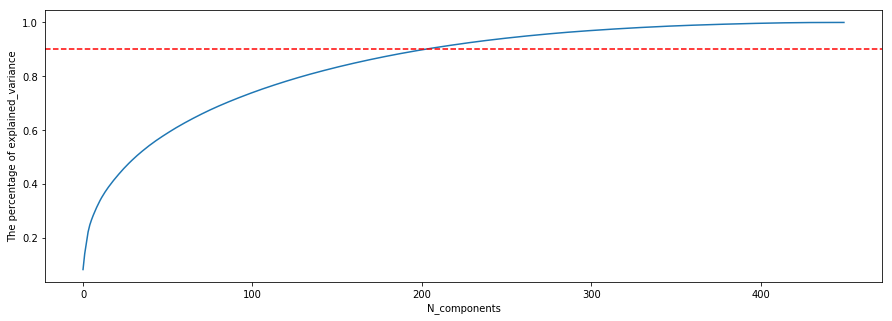

In [41]:
fig4,ax4=plt.subplots(figsize=(15,5))
pd.Series(np.cumsum(pca_initial.explained_variance_ratio_)).plot(kind="line",ax=ax4)
ax4.set_xlabel("N_components")
ax4.set_ylabel("The percentage of explained_variance")
ax4.axhline(0.9, color = "r", linestyle = "--")

In [42]:
variance_explained_cutoff=0.9
n_components=[idx for idx, explained in enumerate(np.cumsum(pca_initial.explained_variance_ratio_)) if explained > variance_explained_cutoff][1]
print('{} components can explain {:.2f} of variance.'.format(n_components, pca_initial .explained_variance_ratio_[:n_components].sum()))

203 components can explain 0.90 of variance.


In [43]:
pca_final=PCA(n_components=n_components)
azdias_pca = pca_final.fit_transform(azdias_cleaned)

In [165]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_final.components_
num_pc = pca_final.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = azdias_cleaned.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,PC186,PC187,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AKT_DAT_KL,-1.154628e-01,2.359432e-02,-8.535738e-02,-1.208131e-01,-3.082432e-02,3.454080e-02,-1.228574e-02,4.231717e-03,2.654385e-04,-7.751802e-03,1.808027e-02,-2.016233e-02,2.828339e-02,-3.498442e-02,4.551857e-02,-8.503050e-02,3.931177e-02,-8.559576e-02,5.884273e-02,8.719901e-02,-2.204666e-02,9.408234e-03,2.424109e-02,-2.041843e-01,1.736028e-03,9.911891e-02,1.030661e-01,-4.087326e-02,-1.008374e-01,9.101928e-02,1.281480e-01,-1.636888e-02,-3.440186e-02,2.631443e-02,1.645611e-02,1.625682e-01,8.810214e-02,2.352073e-02,1.164785e-01,-1.307092e-01,-4.700789e-02,-4.682559e-02,-1.090540e-01,-6.289635e-02,-1.737304e-01,-8.157623e-02,-1.329255e-01,-7.213393e-02,1.630513e-01,-1.823377e-01,-2.010862e-01,1.781342e-01,-1.567226e-01,2.627595e-01,7.499127e-02,-3.325885e-01,1.271664e-01,-2.021633e-01,1.311098e-01,2.579089e-02,-8.306753e-03,2.056662e-01,9.303022e-02,-1.858710e-01,-1.935334e-02,-5.127074e-02,1.185889e-03,-1.117078e-01,-1.781513e-02,-8.564988e-02,-5.421097e-02,3.753279e-02,-3.470206e-02,-3.431452e-02,-3.689569e-02,-1.644393e-01,-3.495138e-02,5.109276e-02,8.904428e-02,8.958627e-03,-6.159612e-02,5.690541e-02,-7.597955e-02,4.525218e-02,3.436226e-02,-2.669288e-02,2.072725e-02,2.478924e-02,5.705010e-02,-1.508998e-02,-3.560536e-02,-7.603772e-03,-3.675232e-03,-1.072866e-01,-3.166071e-02,-3.585591e-04,2.475034e-02,4.343731e-02,-1.779839e-02,1.962307e-02,6.588669e-02,1.624518e-03,-4.465365e-02,-3.773776e-02,4.147363e-02,4.223247e-02,-8.391796e-03,2.605579e-02,-7.724997e-03,-4.393699e-03,6.004521e-03,1.239663e-02,2.542870e-04,5.002727e-02,8.278091e-03,-2.806918e-02,-1.497515e-02,-1.603260e-02,5.567435e-02,-3.069082e-02,3.570657e-02,-6.786088e-03,2.751773e-02,-4.522435e-03,7.533281e-03,-1.274887e-02,2.771155e-02,-4.504947e-03,-7.221694e-03,3.403718e-02,5.973252e-05,-3.097396e-02,-3.159630e-03,1.444367e-02,3.588812e-02,-6.826737e-02,8.470968e-03,8.452028e-03,-1.669410e-02,-2.051942e-02,1.736166e-03,-1.554800e-02,-2.409429e-02,-3.049022e-02,2.513553e-04,1.077135e-02,-1.849786e-02,2.632253e-03,-1.838509e-02,-4.422677e-03,-1.686778e-02,3.868007e-02,-2.470066e-02,1.077942e-03,1.709942e-02,-1.583160e-04,-6.542212e-03,-3.469677e-02,1.375778e-02,-1.382677e-02,-3.205419e-02,3.035688e-02,1.513963e-02,8.650600e-03,1.201753e-02,1.148007e-02,7.455142e-03,1.093427e-02,6.028273e-03,2.266855e-03,3.337095e-03,-2.850911e-02,2.063784e-03,2.336077e-03,-2.504276e-03,-2.109288e-02,1.415682e-02,3.450908e-03,7.751360e-03,-4.004717e-03,-8.301686e-04,-1.110335e-02,1.492473e-04,9.772072e-03,-7.713643e-03,9.485222e-03,1.050491e-03,2.039363e-02,-5.542756e-03,4.814451e-04,-1.600052e-02,-8.008156e-04,3.068800e-02,-1.010813e-02,-8.152040e-03,1.912573e-02,-5.088612e-03,-1.082

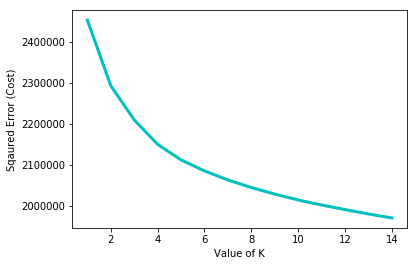

In [154]:
cost =[]
for i in range(1, 15):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(azdias_pca)
      
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
  
 # plot the cost against K values
plt.plot(range(1, 15), cost, color ='c', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

In [166]:
kmeans = KMeans(n_clusters=6, random_state=42, n_jobs=-1).fit(azdias_pca)
general_clusters = kmeans.predict(azdias_pca)

In [167]:
customers_pca =pca_final.transform(customers_cleaned)
customers_clusters  = kmeans.predict(customers_pca)

In [168]:
def get_cluster_distribution(clusters):
    """
    INPUTS:
        clusters- a NumPy array contains the cluster index for each observation

    OUTPUT:
        dis_df- a panda data frame indicates the distribution of different clusters
    """
    dis_df=pd.Series(clusters).value_counts(normalize=True).reset_index()
    dis_df.rename(columns={"index":"cluster",0:"percentage"},inplace=True)
    return dis_df

In [169]:
# K means give some centroids which define the clusters (each data point is in the cluster of the centroid it's closest to).
# cluster_centers_ returns Coordinates of cluster centers.
kmeans.cluster_centers_

array([[ -1.50973257e+00,  -1.14509543e+00,   3.27125853e-01, ...,
          3.45396742e-03,   3.61144442e-03,   9.24565851e-03],
       [ -2.97291679e-01,   6.97781713e-01,  -9.98390858e-01, ...,
          4.43842759e-03,  -8.27988124e-03,  -5.89737467e-03],
       [  1.91900402e+00,   1.15286755e+00,   2.58753754e-01, ...,
         -1.68774664e-03,   7.28142403e-04,   3.65016270e-04],
       [  9.46165189e-01,  -1.44923659e+00,  -9.85840383e-01, ...,
         -3.51695910e-03,  -6.11410900e-04,   3.99134830e-03],
       [  9.00433807e-01,  -1.03272255e+00,   1.32864159e+00, ...,
         -1.23105592e-03,   2.35304662e-03,  -2.51828363e-03],
       [ -1.99333893e+00,   1.47131511e+00,   2.29713464e-01, ...,
         -2.45157563e-03,   2.03108254e-03,  -8.04284903e-03]])

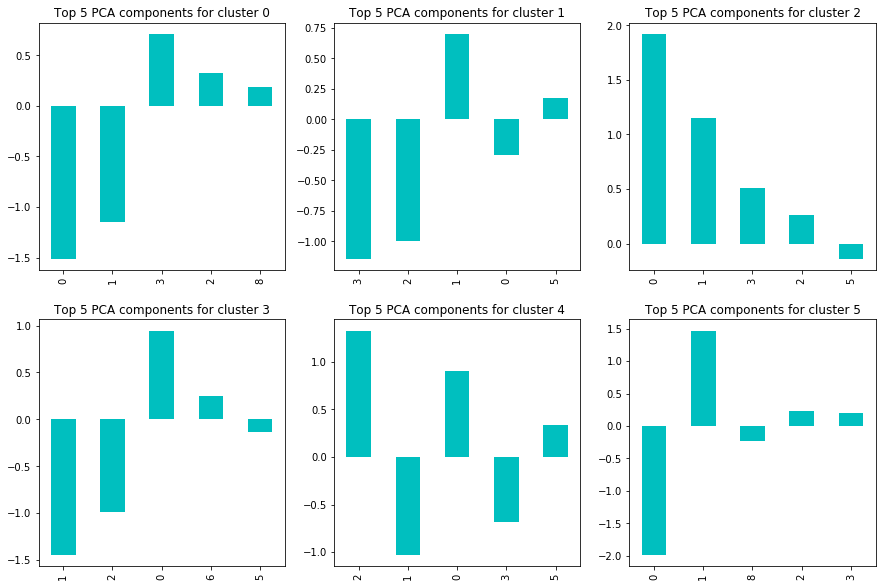

In [170]:
fig6,((ax6_1,ax6_2,ax6_3),(ax6_4,ax6_5,ax6_6))=plt.subplots(nrows=2,ncols=3,figsize=(15,10))
axes=[ax6_1,ax6_2,ax6_3,ax6_4,ax6_5,ax6_6]
for i in range(6):
    comp_weight = pd.DataFrame(kmeans.cluster_centers_).loc[i]
    comp_weight = comp_weight.iloc[comp_weight.abs().argsort()][::-1]
    top_comps=comp_weight.head(5)
    top_comps.plot(kind='bar', title='Top 5 PCA components for cluster {}'.format(i),
                  ax=axes[i],color="c")

In [171]:
general_dis_df = get_cluster_distribution(general_clusters)
customer_dis_df =get_cluster_distribution(customers_clusters)

In [172]:
comp_df=general_dis_df.merge(customer_dis_df,on="cluster")
comp_df.sort_values(by="cluster",inplace=True)
comp_df.rename(columns={"percentage_x":"percentage_general","percentage_y":"percentage_customer"},inplace=True)
comp_df["diff"]=comp_df["percentage_customer"]-comp_df["percentage_general"]
comp_df

,cluster,percentage_general,percentage_customer,diff
1,0,0.197589,0.158800,-0.038789
2,1,0.165575,0.014083,-0.151493
0,2,0.205795,0.261694,0.055899
3,3,0.154343,0.221853,0.067510
5,4,0.123773,0.310948,0.187174
4,5,0.152925,0.032623,-0.120301


In [175]:
def understand_pca(df, pca,n_top_var,components):
    """
    understand_pca gives the bar chart of the top features in a component
    INPUTS:
        df- a NumPy array contains the cluster index for each observation
        pca - a scikit-learn estimator, using SVD of the data to project it to a lower-dimensional space.
        n_top_var - the number of top features
        components - a python list of components that needs to be visualized
    OUTPUT:
        None
    """
    fig5,(ax5_1,ax5_2,ax5_3)=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
    axes=[ax5_1,ax5_2,ax5_3]
    for i in range(len(components)):
        var_weight = pd.DataFrame(pca.components_,columns=df.columns).loc[components[i]]
        var_weight = var_weight.iloc[var_weight.abs().argsort()]
        top_var_series = var_weight.tail(n_top_var)
        top_var_series.plot(kind='bar', 
                  title='Top {} weighted features for PCA component {}'.format(n_top_var,components[i] ),
                  ax=axes[i],color="c")
    
    return None

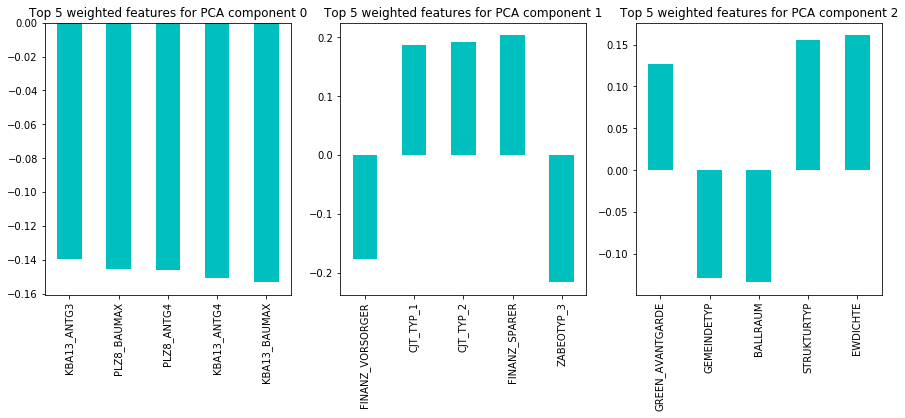

In [176]:
understand_pca(azdias_cleaned, pca_final,5,[0,1,2])

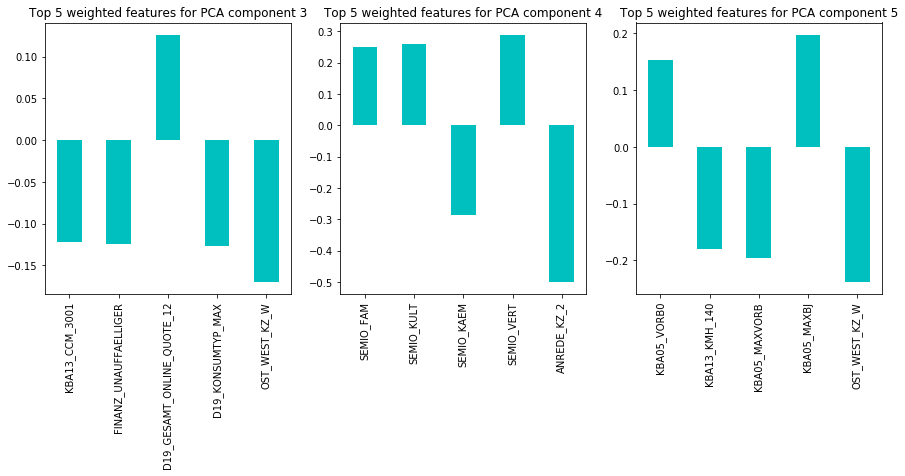

In [179]:
understand_pca(azdias_cleaned, pca_final,5,[3,4,5])

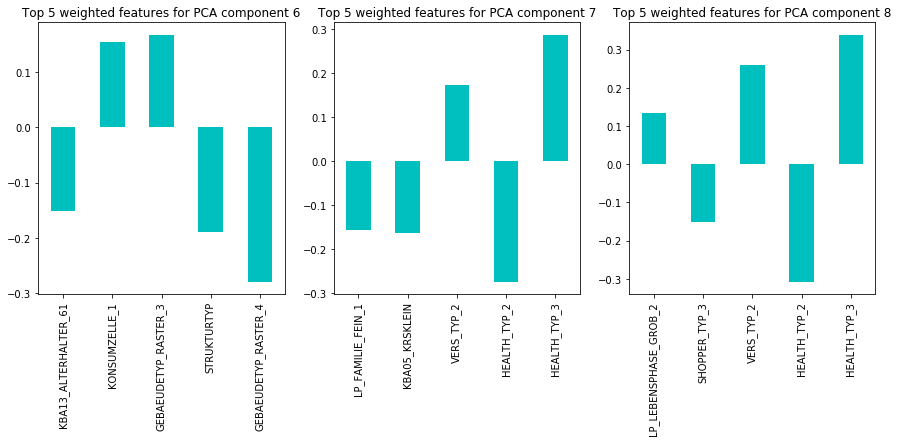

In [180]:
understand_pca(azdias_cleaned, pca_final,5,[6,7,8])

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [51]:
mailout_train=pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
train_cleaned=data_preprocessing(mailout_train,attribute_unknown,cols_drop1,cols_drop2,cat_cols,num_cols,skewed_cols,"train")
y= train_cleaned["RESPONSE"]
X = train_cleaned.drop("RESPONSE",axis=1)

In [52]:
mailout_train.shape,train_cleaned.shape

((42962, 367), (35094, 451))

In [55]:
mailout_train.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [57]:
train_cleaned.head(5)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA

In [53]:
## stratify parameter will preserve the proportion of target as in original dataset,
# in the train and test datasets as well.
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

The AUC score for LR is 0.6727478608885373
The AUC score for RFC is 0.5230780325977211
The AUC score for GBC is 0.7264523659128174
The AUC score for SVC is 0.5847330193261944


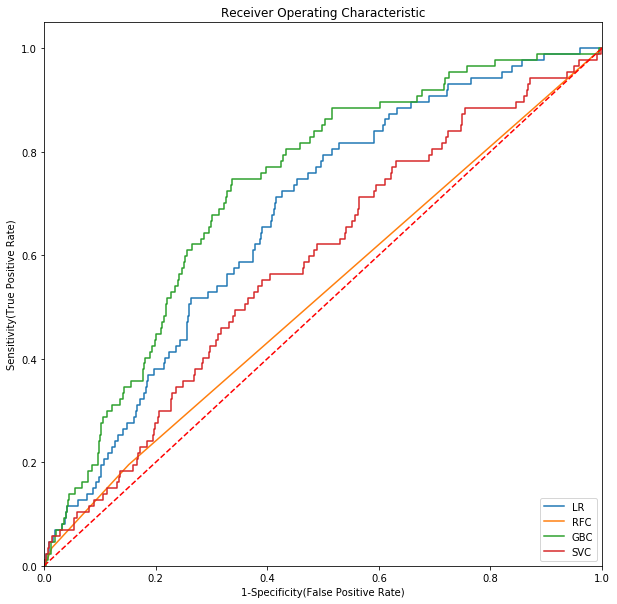

In [36]:
models = {'LR':LogisticRegression(), 'RFC':RandomForestClassifier(random_state=42),\
          'GBC':  GradientBoostingClassifier(random_state=42),\
          "SVC": SVC(kernel='linear', probability=True,random_state=42)}

#loop through the models and evaluate basic performance
fig = plt.figure(figsize = (10,10))
for m in models:
    model=models[m].fit(X_train,y_train)
    fpr, tpr, thresholds = roc_curve(y_val,model.predict_proba(X_val)[:,1])
    plt.plot(fpr,tpr,label=m)
    auc=roc_auc_score(y_val,model.predict_proba(X_val)[:,1])
    print("The AUC score for {} is {}".format(m,auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [43]:
parameters = {
    "learning_rate": [0.1,0.2],
    "min_samples_split": [2,5,8],
    "max_depth":[3,5,8]
    }

In [44]:
gbc = GradientBoostingClassifier(random_state=42)
cv = GridSearchCV(estimator = gbc, param_grid = parameters,scoring = "roc_auc",
                    cv =2,n_jobs = -1,verbose=3)
cv.fit(X_train,y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2 .............
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, score=0.6463085879140693, total=  24.9s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2 .............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, score=0.6662144145072382, total=  22.6s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=5 .............


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   47.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=5, score=0.643759517799186, total=  21.7s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=5 .............
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=5, score=0.6555998145381485, total=  22.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=8 .............
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=8, score=0.6403433104940499, total=  21.7s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=8 .............
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=8, score=0.6665259904178044, total=  21.8s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2 .............
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, score=0.6391027767760548, total=  57.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=2 .............
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=2, score=0.6667761578486425, total=  58.6s
[CV] learning_rate=0.1, max_depth=5, min_samples_spl

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 37.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2], 'min_samples_split': [2, 5, 8], 'max_depth': [3, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [46]:
best_gbc=cv.best_estimator_
auc_cv=roc_auc_score(y_val,best_gbc.predict_proba(X_val)[:,1])
print("The best parameters are {}".format(cv.best_params_))
print("The mean cross-validated auc score of the best_estimator is {}, the validation data auc score is {}".format(cv.best_score_,auc_cv))

The best parameters are {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2}
The mean cross-validated auc score of the best_estimator is 0.6562615012106537, the validation data auc score is 0.7264523659128174


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [74]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
test_cleaned=data_preprocessing(mailout_test,attribute_unknown,cols_drop1,cols_drop2,cat_cols,num_cols,skewed_cols,"test")

In [75]:
mailout_test.shape,test_cleaned.shape

((42833, 366), (42833, 451))

In [59]:
mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [60]:
test_cleaned.head(5)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA

In [ ]:
test_cleaned_pre=test_cleaned.drop("LNR",axis=1)
pred_test=best_gbc.predict_proba(test_cleaned_pre)[:,1]
test_cleaned["RESPONSE"]=pred_test

In [77]:
pred_test_df=test_cleaned[["LNR","RESPONSE"]]
pred_test_df.head(5)

,LNR,RESPONSE
0,1754,0.024905
1,1770,0.022530
2,1465,0.002806
3,1470,0.002609
4,1478,0.006849


In [78]:
pred_test_df.isnull().sum()

LNR         0
RESPONSE    0
dtype: int64

In [80]:
pred_test_df.to_csv("kaggle.csv",index=False)